In [1]:
try:
    from google.colab import drive
    drive.mount("/content/gdrive/")
except:
    pass

In [ ]:
import os
from datetime import datetime
from pathlib import Path

import numpy as np
import torch
from diffusers import UNet2DModel, DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm

from config.char2char_config import TrainingConfigChar2Char
from utils.eval_utils import evalaute_char_to_image_grid
from utils.train_utils import get_paired_dataloader
from utils.utils import get_repo_dir
from models.old_scz_c2c import Char2CharModel

In [3]:
%load_ext autoreload
%autoreload 2

In [11]:
ROOT_IMAGE_DIR = get_repo_dir() / Path("data/data_char2char")

In [ ]:
cfg = TrainingConfigChar2Char( # TODO
    image_size=32,
    train_batch_size=32,
    eval_batch_size=16,
    encoder_dim=1024,
    save_image_epochs=1,
    save_model_epochs=5,
)

In [13]:
train_dataloader = get_paired_dataloader(cfg, ROOT_IMAGE_DIR)
eval_dataloader = DataLoader(train_dataloader.dataset, batch_size=cfg.eval_batch_size, shuffle=False)

In [14]:
# model = Char2CharModel(cfg)
model = UNet2DModel(    
    sample_size=cfg.image_size,
    in_channels=1,
    out_channels=1,
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D"),
    block_out_channels=(32, 64, 128, 128),
    layers_per_block=2,
    class_embed_type="identity",
    num_class_embeds=2,
)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Model Parameters: {total_params:,}")

Total Model Parameters: 6,005,825


In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=cfg.lr_warmup_steps,
    num_training_steps=len(train_dataloader) * cfg.num_epochs,
)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [ ]:
def train_loop(
    cfg: TrainingConfigRand2Char,
    train_dataloader: DataLoader,
    eval_dataloader: DataLoader,
    model: Char2CharModel,
    optimizer: torch.optim.Optimizer,
    lr_scheduler: torch.optim.lr_scheduler.LRScheduler,
    noise_scheduler: DDPMScheduler,
):
    device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
    model = model.to(device)

    # Tensorboard logging
    if cfg.output_dir is not None:
        os.makedirs(cfg.output_dir, exist_ok=True)
    run_name = f"train_char2char_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    log_dir = str(Path(cfg.output_dir) / "logs" / run_name)
    writer = SummaryWriter(log_dir=log_dir)

    # Train loop
    global_step = 0
    for epoch in range(cfg.num_epochs):
        pbar = tqdm(train_dataloader, desc=f"Epoch {epoch}")
        total_loss = 0

        model.train()
        for (b_imgs_src, b_imgs_trg, b_labels) in pbar:
            b_imgs_src = b_imgs_src.to(device)
            b_imgs_trg = b_imgs_trg.to(device)
            b_labels = b_labels.to(device)

            # noise = torch.randn_like(b_imgs_src)
            # timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (b_imgs_src.shape[0],), device=device).long()
            # b_imgs_src_noisy = noise_scheduler.add_noise(b_imgs_src, noise, timesteps)
            timesteps = torch.full((b_imgs_src.shape[0],), 1, device=device).long()

            optimizer.zero_grad()
            # noise_pred = model(b_imgs_src_noisy, timesteps, b_labels, b_imgs_src).sample
            pred_img = model(b_imgs_src, timesteps, class_labels=b_labels.unsqueeze(1)).sample
            # loss = torch.nn.functional.mse_loss(noise_pred, noise)
            loss = torch.nn.functional.mse_loss(pred_img.float(), b_imgs_trg.float(), reduction="mean")

            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            pbar.set_postfix(**logs)
            writer.add_scalar("Loss/train", logs["loss"], global_step)
            writer.add_scalar("LR", logs["lr"], global_step)
            global_step += 1
            total_loss += logs["loss"]

        writer.add_scalar("Loss/train_epoch", total_loss / len(train_dataloader), epoch)

        model.eval()

        # Save model checkpoint
        if epoch % cfg.save_model_epochs == 0 or epoch == cfg.num_epochs - 1:
            if epoch > 0:
                save_dir = Path(cfg.output_dir) / "models" / run_name
                os.makedirs(save_dir, exist_ok=True)
                torch.save(model.state_dict(), save_dir / f"{run_name}_epoch_{epoch}.pth")
                torch.save(model.state_dict(), save_dir / f"{run_name}_latest.pth")

        # Evaluate and log images
        if epoch % cfg.save_image_epochs == 0 or epoch == cfg.num_epochs - 1:
            img_grid = evalaute_char_to_image_grid(model, eval_dataloader, device)
            writer.add_image("eval_imgs", img_grid, global_step, dataformats="CWH")
        writer.flush()
    writer.close()

In [17]:
# Train model
train_loop(cfg, train_dataloader, eval_dataloader, model, optimizer, lr_scheduler, noise_scheduler)

Epoch 0:   0%|          | 0/374 [00:00<?, ?it/s]

torch.Size([16, 1, 32, 32]) torch.Size([16, 1, 32, 32]) torch.Size([16, 1, 32, 32]) torch.Size([48, 1, 32, 32])
torch.Size([3, 546, 104])


Epoch 1:   0%|          | 0/374 [00:00<?, ?it/s]

torch.Size([16, 1, 32, 32]) torch.Size([16, 1, 32, 32]) torch.Size([16, 1, 32, 32]) torch.Size([48, 1, 32, 32])
torch.Size([3, 546, 104])


Epoch 2:   0%|          | 0/374 [00:00<?, ?it/s]

torch.Size([16, 1, 32, 32]) torch.Size([16, 1, 32, 32]) torch.Size([16, 1, 32, 32]) torch.Size([48, 1, 32, 32])
torch.Size([3, 546, 104])


Epoch 3:   0%|          | 0/374 [00:00<?, ?it/s]

torch.Size([16, 1, 32, 32]) torch.Size([16, 1, 32, 32]) torch.Size([16, 1, 32, 32]) torch.Size([48, 1, 32, 32])
torch.Size([3, 546, 104])


Epoch 4:   0%|          | 0/374 [00:00<?, ?it/s]

torch.Size([16, 1, 32, 32]) torch.Size([16, 1, 32, 32]) torch.Size([16, 1, 32, 32]) torch.Size([48, 1, 32, 32])
torch.Size([3, 546, 104])


Epoch 5:   0%|          | 0/374 [00:00<?, ?it/s]

torch.Size([16, 1, 32, 32]) torch.Size([16, 1, 32, 32]) torch.Size([16, 1, 32, 32]) torch.Size([48, 1, 32, 32])
torch.Size([3, 546, 104])


Epoch 6:   0%|          | 0/374 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# from line_profiler import LineProfiler
# lp = LineProfiler()
# lp.add_function(train_loop)
# lp.run("train_loop(cfg, train_dataloader, model, optimizer, lr_scheduler, noise_scheduler, inference_scheduler)")
# lp.print_stats(sort=True)

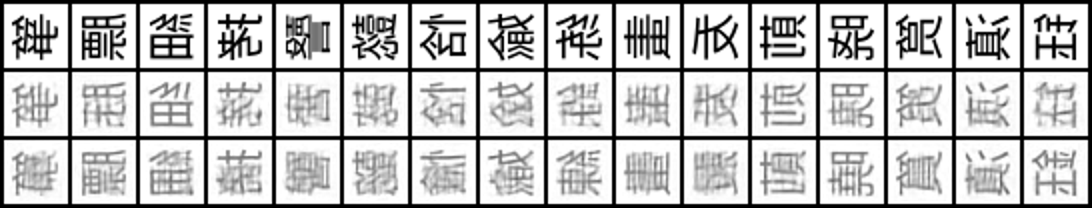

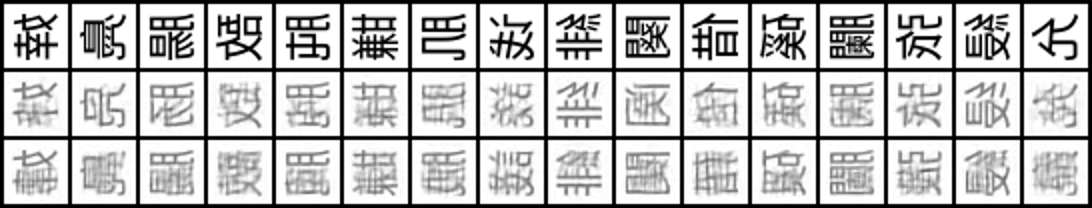

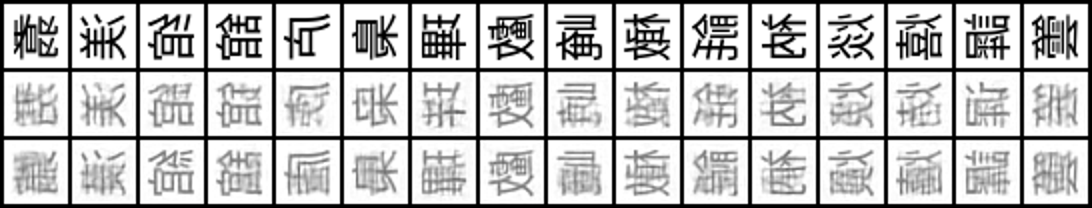

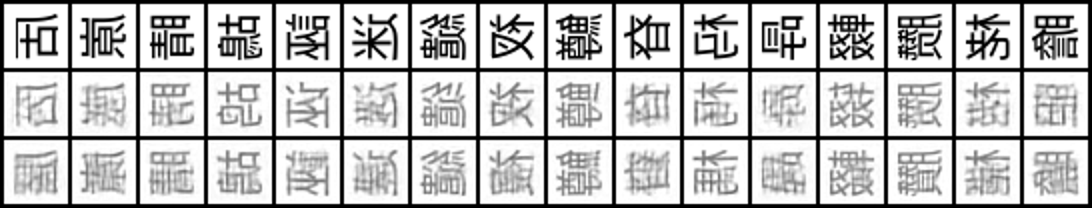

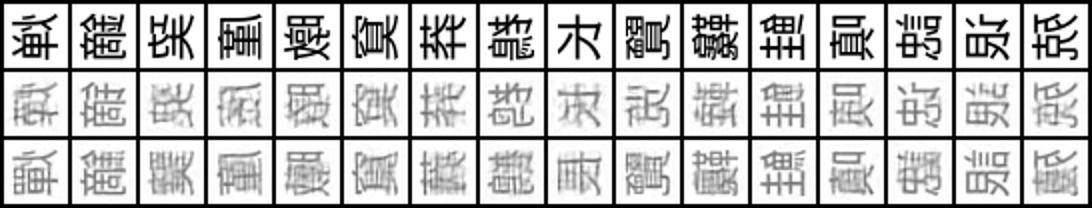

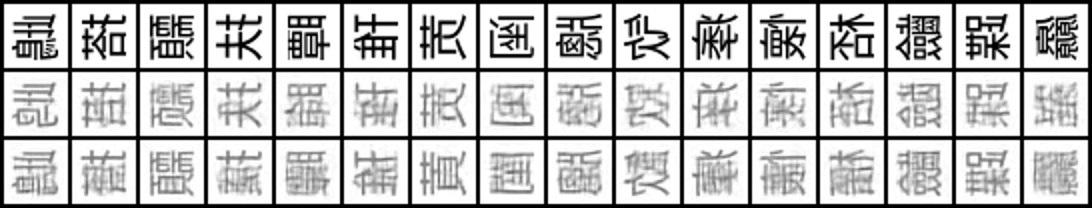

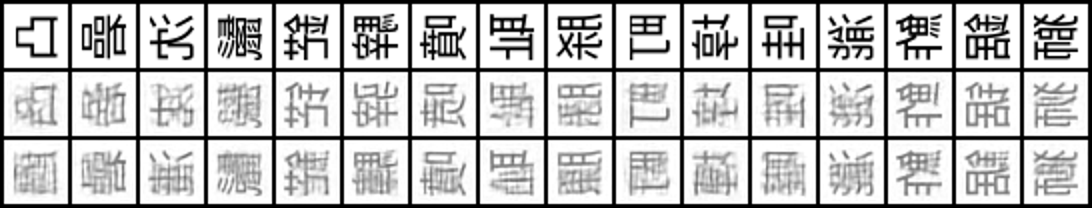

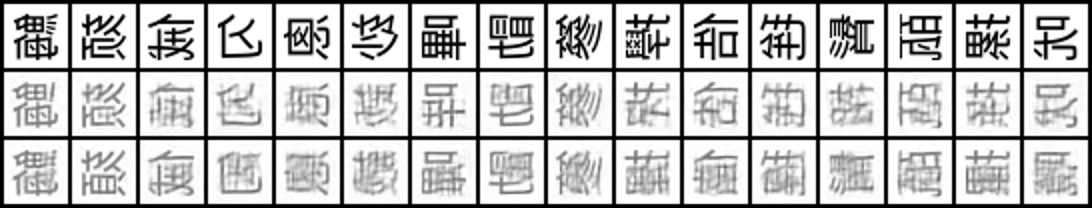

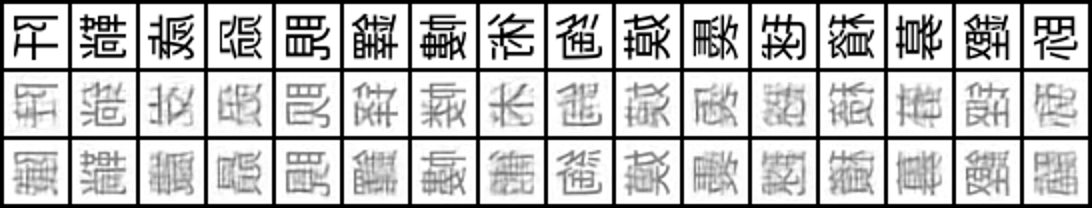

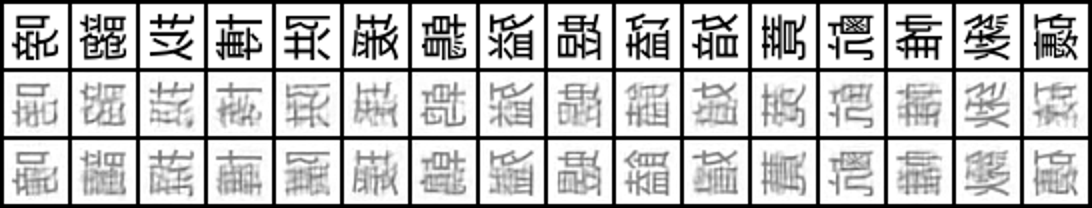

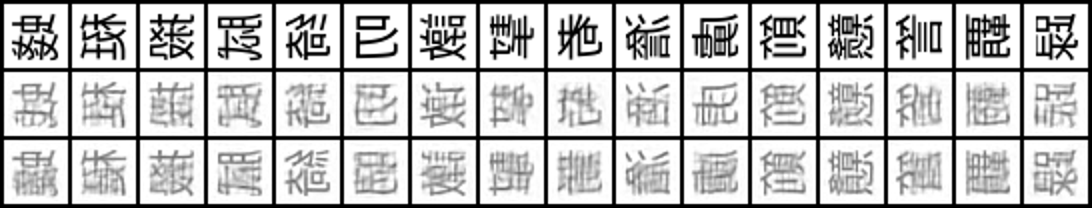

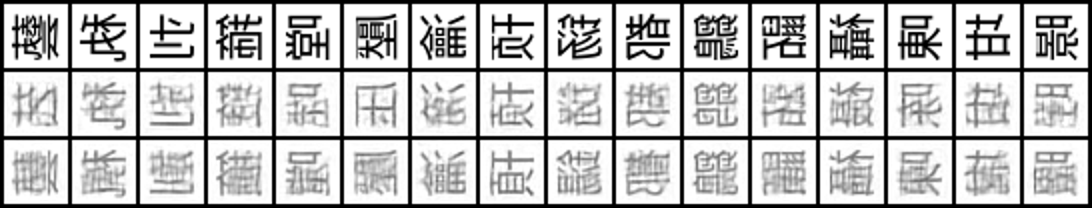

In [40]:
from utils.train_utils import get_dataloader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from config.char2char_config import TrainingConfigChar2Char
from PIL import Image

test_cfg = TrainingConfigChar2Char(**cfg.__dict__)
test_cfg.train_batch_size = test_cfg.eval_batch_size

test_dataloader = get_dataloader(test_cfg, get_repo_dir() / Path("data/data"))

device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

model.eval()
model.to(device)
with torch.no_grad():
    for b_ix, b_imgs_src in enumerate(test_dataloader):
        b_imgs_src = b_imgs_src.to(device)
        b_labels_s = torch.zeros(b_imgs_src.shape[0], dtype=torch.long, device=device)
        b_labels_t = torch.ones(b_imgs_src.shape[0], dtype=torch.long, device=device)
        B, C, H, W = b_imgs_src.shape

        timesteps = torch.full((b_imgs_src.shape[0],), 1, device=device).long()
        pred_imgs_s = model(b_imgs_src, timesteps, class_labels=b_labels_s.unsqueeze(1)).sample
        pred_imgs_t = model(b_imgs_src, timesteps, class_labels=b_labels_t.unsqueeze(1)).sample

        # Convert pred_imgs from (B, 1, H, W) [-1, 1] to (B, 1, H, W) [0, 255]
        pred_imgs_s = (pred_imgs_s / 2 + 0.5).clamp(0, 1)
        pred_imgs_s = (pred_imgs_s * 255).to(torch.uint8).cpu()
        pred_imgs_t = (pred_imgs_t / 2 + 0.5).clamp(0, 1)
        pred_imgs_t = (pred_imgs_t * 255).to(torch.uint8).cpu()

        b_imgs_src = (b_imgs_src * 255).to(torch.uint8).cpu()

        triplets = torch.stack([b_imgs_src, pred_imgs_s, pred_imgs_t]).transpose(1, 0).reshape(B*3, C, H, W)
        img_grid = make_grid(triplets, nrow=3, padding=2, normalize=False)
        G_C, G_H, G_W = img_grid.shape
        img_grid_pil = Image.fromarray(img_grid.permute(2, 1, 0).numpy()).resize((G_H*2, G_W*2))
        display(img_grid_pil)
        if b_ix > 10: break